In [1]:
import numpy as np
import osmnx as ox
import networkx as nx
import time

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle, os
import glob
import mlrfit as mf
import lrrouting as ldr

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mtype = "ego_social"

G = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype=int)

print(f"{G.number_of_edges()=}, {G.number_of_nodes()=}")

Adj, Dist = ldr.nx_graph_to_matrices(G)

m = n = Dist.shape[0]
diam_G = Dist.max()
w_min = Dist[Dist>0].min()
print(m, diam_G, w_min, (Adj>0).sum())
print(f"{n=}")
print(np.histogram(Dist.flatten(), bins=5, density=True))
print(f"{Adj[Adj>0].mean()=}, {Adj[Adj>0].min()=}, {Adj[Adj>0].max()=}")

G.number_of_edges()=88234, G.number_of_nodes()=4039
in  degrees: {0: 0, 1: 75, 2: 98, 3: 93, 4: 99, 5: 93, 6: 98, 7: 98, 8: 111, 9: 100, 10: 95, 11: 81, 12: 82, 13: 79, 14: 87, 15: 106, 16: 82, 17: 76, 18: 73, 19: 72, 20: 63, 21: 52, 22: 63, 23: 53, 24: 60, 25: 55, 26: 56, 27: 49, 28: 37, 29: 38, 30: 40, 31: 38, 32: 44, 33: 35, 34: 43, 35: 36, 36: 43, 37: 43, 38: 44, 39: 29, 40: 27, 41: 29, 42: 21, 43: 29, 44: 21, 45: 19, 46: 24, 47: 24, 48: 24, 49: 33, 50: 25, 51: 20, 52: 19, 53: 15, 54: 23, 55: 23, 56: 18, 57: 23, 58: 15, 59: 11, 60: 18, 61: 18, 62: 16, 63: 23, 64: 13, 65: 20, 66: 22, 67: 13, 68: 16, 69: 14, 70: 17, 71: 18, 72: 15, 73: 10, 74: 10, 75: 8, 76: 15, 77: 10, 78: 11, 79: 16, 80: 8, 81: 4, 82: 12, 83: 17, 84: 12, 85: 10, 86: 9, 87: 5, 88: 9, 89: 9, 90: 7, 91: 9, 92: 10, 93: 11, 94: 7, 95: 9, 96: 11, 97: 8, 98: 5, 99: 11, 100: 10, 101: 4, 102: 9, 103: 6, 104: 6, 105: 7, 106: 9, 107: 9, 108: 6, 109: 9, 110: 4, 111: 1, 112: 7, 113: 8, 114: 4, 115: 10, 116: 6, 117: 9, 118: 0, 1

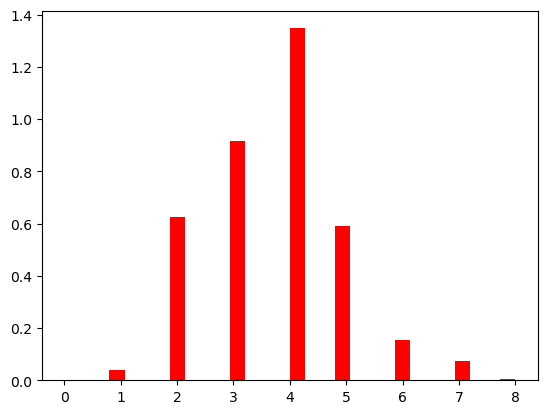

In [3]:
counts, bins = np.histogram(Dist, bins=30, density=True)
# plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts, color='r')
plt.show()

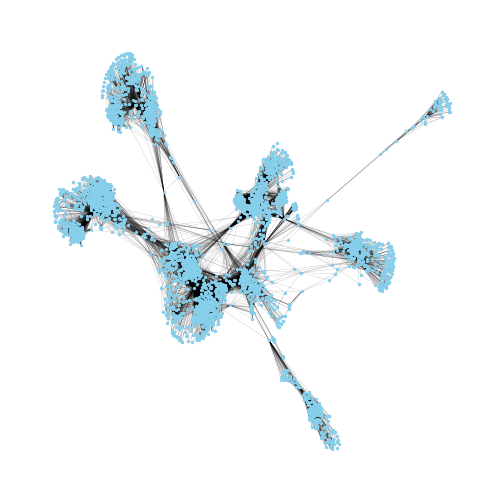

In [4]:
ldr.plot_nx_G(G, with_labels=False, node_size=1, f_layout=nx.spring_layout, width=0.05)

In [5]:
coeff = 1
search_pattern = os.path.join("outputs/", f'*{mtype + "_nsp%d_"%coeff}*{n}*.pickle')
matching_files = sorted(glob.glob(search_pattern))
info_ranks = {}

for fname in matching_files:
    rank = int(fname.split("_")[3][4:])
    with open(fname, 'rb') as handle:
        d1 = pickle.load(handle)[rank]
    info_ranks[rank/2] = {r"$|I|/n=%d\%%$"%(coeff):d1["symm"]}
    for ns in [10, 100]:
        fname2 = fname.replace('nsp1', "nsp%d")%ns
        with open(fname2, 'rb') as handle:
            d2 = pickle.load(handle)[rank]
        info_ranks[rank/2][r"$|I|/n=%d\%%$"%(ns)] = d2["symm"]

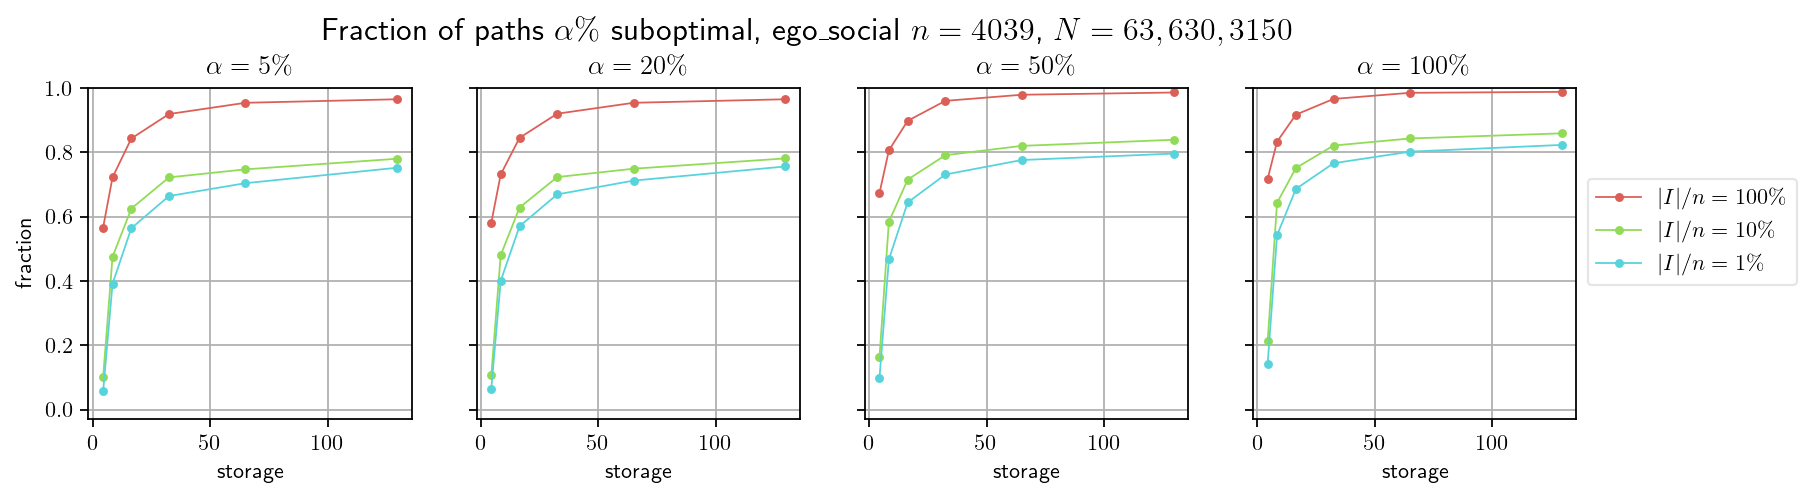

In [6]:
ldr.plot_fracs_subopt(info_ranks, list(info_ranks.keys()), fracs = [1.05, 1.2, 1.5, 2.0], dpi=160, figsize=(12, 3), 
                      marker='.', 
                      mtype=mtype+r" $n=%d$, $N=%d, %d, %d$"%(n, int(np.sqrt(n))*1, int(np.sqrt(n))*10, int(np.sqrt(n))*50), 
                      ylim=[-3e-2, 1])

In [7]:
sorted(info_ranks.keys())

[4.5, 8.5, 16.5, 32.5, 65.0, 129.5]

In [8]:
ranks = sorted(info_ranks.keys())
info_ranks2 = {r:info_ranks[r] for r in ranks}

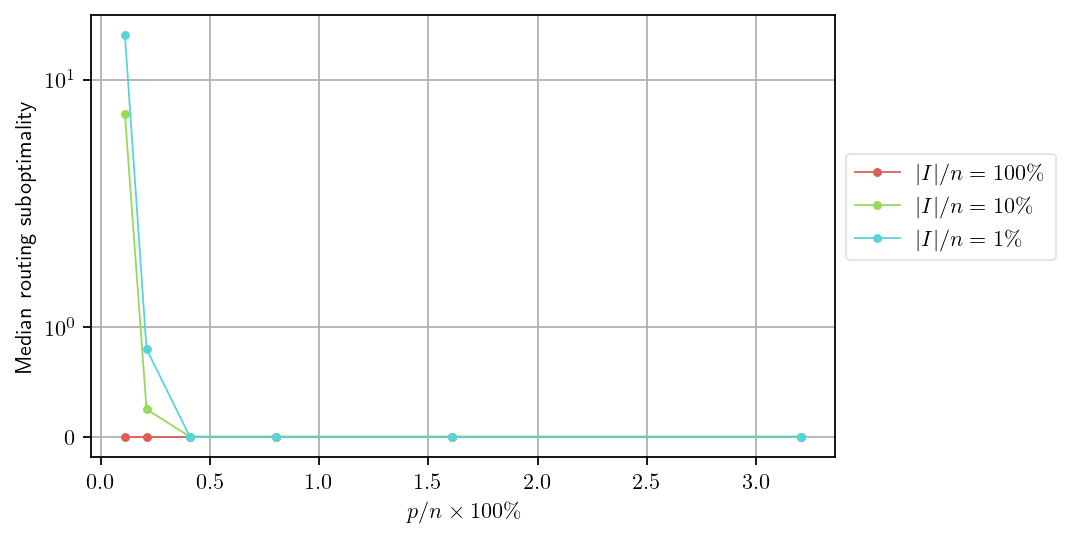

In [9]:
ldr.plot_median_storage(n, info_ranks2, list(info_ranks.keys()), 
                      dpi=160, figsize=(6, 4), marker='.', 
                      mtype=mtype+r" $n=%d$"%(n), 
                      yticks=None, yscale='symlog', 
                      symm=True)

In [10]:
r = list(info_ranks.keys())[0]
algos = sorted(info_ranks[r].keys())

ranks = np.array(sorted(info_ranks.keys()))

emb_rel_diff = {algo:[] for algo in algos}
for rank in ranks:
    rats = info_ranks[rank][r"$|I|/n=100\%$"]
    print(rank, np.round(rank / n  * 100, 1), np.median(rats["ratios"]))
    ldr.print_stats_moments(rats["r_rel_diff"])

4.5 0.1 1.0
mean=13.52, M=8.38, SD=15.74, q_25=3.89, q_75=15.94, max=232.67, min=0.00
8.5 0.2 1.0
mean=7.31, M=4.26, SD=10.01, q_25=1.95, q_75=8.20, max=164.26, min=0.00
16.5 0.4 1.0
mean=4.82, M=2.89, SD=6.85, q_25=1.35, q_75=5.46, max=160.35, min=0.00
32.5 0.8 1.0
mean=3.74, M=2.30, SD=5.90, q_25=1.09, q_75=4.18, max=157.68, min=0.00
65.0 1.6 1.0
mean=3.22, M=1.99, SD=5.64, q_25=0.97, q_75=3.46, max=157.76, min=0.00
129.5 3.2 1.0
mean=3.00, M=1.86, SD=5.61, q_25=0.94, q_75=3.09, max=157.64, min=0.00


In [11]:
np.round(ranks / n  * 100, 2)

array([0.11, 0.21, 0.41, 0.8 , 1.61, 3.21])

In [12]:
r = list(info_ranks.keys())[0]
algos = sorted(info_ranks[r].keys())

ranks = np.array(sorted(info_ranks.keys()))

emb_rel_diff = {algo:[] for algo in algos}
for rank in ranks:
    rats = info_ranks[rank][r"$|I|/n=10\%$"]
    print(rank, np.round(rank / n  * 100, 1), np.median(rats["ratios"]))
    ldr.print_stats_moments(rats["r_rel_diff"])
    ldr.print_stats_moments(rats["c_rel_diff"])

4.5 0.1 7.708333333333334
mean=6.50, M=3.17, SD=13.88, q_25=1.55, q_75=5.64, max=410.94, min=0.00
mean=30.34, M=23.08, SD=29.67, q_25=10.31, q_75=39.10, max=739.85, min=0.00
8.5 0.2 1.25
mean=3.39, M=1.12, SD=9.34, q_25=0.45, q_75=2.74, max=173.31, min=0.00
mean=16.04, M=9.26, SD=22.73, q_25=3.22, q_75=15.95, max=288.02, min=0.00
16.5 0.4 1.0
mean=2.43, M=0.78, SD=7.19, q_25=0.31, q_75=1.91, max=153.85, min=0.00
mean=10.49, M=5.51, SD=15.25, q_25=2.20, q_75=10.56, max=202.11, min=0.00
32.5 0.8 1.0
mean=2.11, M=0.76, SD=6.11, q_25=0.32, q_75=1.75, max=134.13, min=0.00
mean=9.33, M=4.74, SD=14.14, q_25=1.52, q_75=8.95, max=185.06, min=0.00
65.0 1.6 1.0
mean=1.95, M=0.74, SD=5.56, q_25=0.32, q_75=1.62, max=132.36, min=0.00
mean=8.41, M=4.28, SD=12.80, q_25=1.35, q_75=8.17, max=183.89, min=0.00
129.5 3.2 1.0
mean=1.86, M=0.68, SD=5.39, q_25=0.30, q_75=1.47, max=132.41, min=0.00
mean=7.65, M=4.02, SD=11.47, q_25=1.25, q_75=7.64, max=183.28, min=0.00


In [13]:
r = list(info_ranks.keys())[0]
algos = sorted(info_ranks[r].keys())

ranks = np.array(sorted(info_ranks.keys()))

emb_rel_diff = {algo:[] for algo in algos}
for rank in ranks:
    rats = info_ranks[rank][r"$|I|/n=1\%$"]
    print(rank, np.median(rats["ratios"]))
    ldr.print_stats_moments(rats["r_rel_diff"])
    ldr.print_stats_moments(rats["c_rel_diff"])

4.5 17.8
mean=4.05, M=2.13, SD=8.85, q_25=1.19, q_75=3.69, max=217.20, min=0.00
mean=35.86, M=24.70, SD=28.25, q_25=12.99, q_75=51.31, max=243.12, min=0.00
8.5 1.8
mean=1.88, M=0.59, SD=6.15, q_25=0.27, q_75=1.37, max=99.37, min=0.00
mean=17.92, M=11.21, SD=21.72, q_25=4.70, q_75=21.58, max=304.54, min=0.00
16.5 1.0
mean=1.25, M=0.46, SD=3.67, q_25=0.18, q_75=1.11, max=79.70, min=0.00
mean=10.42, M=6.25, SD=13.56, q_25=2.85, q_75=12.62, max=208.88, min=0.00
32.5 1.0
mean=0.87, M=0.33, SD=2.59, q_25=0.14, q_75=0.73, max=73.12, min=0.00
mean=9.63, M=6.05, SD=12.29, q_25=2.55, q_75=11.73, max=212.08, min=0.00
65.0 1.0
mean=0.70, M=0.22, SD=2.39, q_25=0.10, q_75=0.48, max=73.39, min=0.00
mean=9.56, M=5.91, SD=12.21, q_25=2.33, q_75=12.06, max=212.36, min=0.00
129.5 1.0
mean=0.63, M=0.15, SD=2.37, q_25=0.06, q_75=0.37, max=73.81, min=0.00
mean=9.48, M=5.94, SD=12.09, q_25=2.35, q_75=12.13, max=212.27, min=0.00
